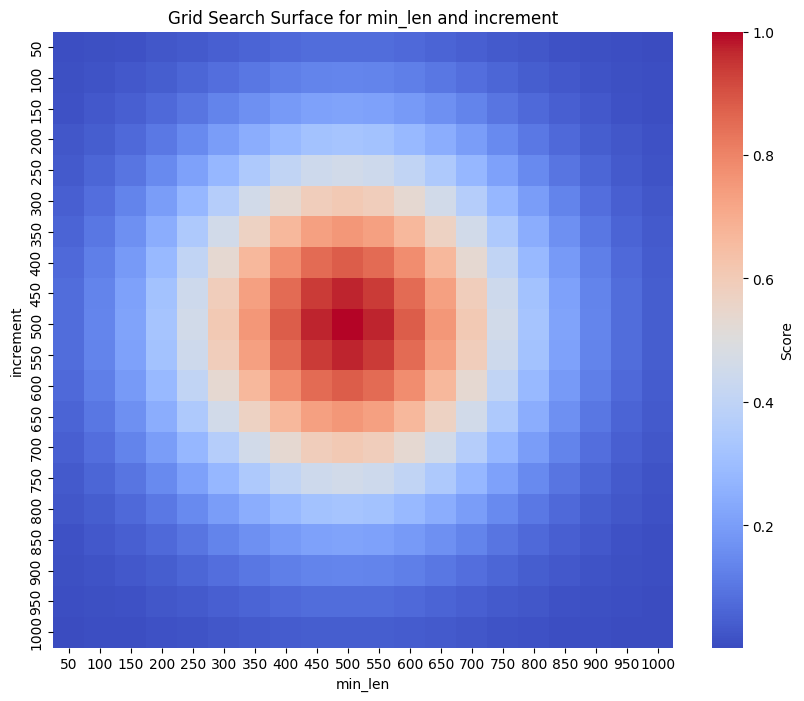

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define hyperparameter ranges
min_lens = np.arange(50, 1050, 50)
increments = np.arange(50, 1050, 50)


# Example grid search results (replace this with your actual scores)
# For demonstration, we'll use a synthetic function
def score_function(min_len, increment):
    return np.exp(-((min_len - 500) ** 2 + (increment - 500) ** 2) / (2 * 200**2))


Z = np.array([[score_function(m, i) for m in min_lens] for i in increments])

# Convert to DataFrame for seaborn
df = pd.DataFrame(Z, index=increments, columns=min_lens)

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df, annot=False, cmap="coolwarm", cbar_kws={"label": "Score"})
plt.title("Grid Search Surface for min_len and increment")
plt.xlabel("min_len")
plt.ylabel("increment")
plt.show()

In [14]:
embedder = get_embedder(model_name="BAAI/bge-small-en", device="mps")
# example = {
#     "source_doi": "10.12942/lrsp-2011-4",
#     "sent_original": "This is achieved by performing the inversion employing Artificial Neural Networks (ANNs; Carroll and Staude, 2001 , see Section 1.3) that have been previously trained with snapshots of MHD simulations, which are given in the z -scale. ",
#     "sent_no_cit": "This is achieved by performing the inversion employing Artificial Neural Networks (ANNs; Carroll and , see Section 1.3) that have been previously trained with snapshots of MHD simulations, which are given in the z -scale. ",
#     "sent_idx": 182,
#     "citation_dois": ["10.1086/320984"],
#     # "pubdate": "2011-12-31"
#     "pubdate": "2025-04-01"
# }

example = {
    "source_doi": "10.1016/0012-8252(86)90017-6",
    "sent_original": "After Kohout et al., 1977. type of flow is involved in the formation of the Boulder Zone and subsurface dolomites. ",
    "sent_no_cit": "After . type of flow is involved in the formation of the Boulder Zone and subsurface dolomites. ",
    "sent_idx": 477,
    "citation_dois": ["10.1016/0016-7037(77)90238-1"],
    "pubdate": "1986-12-31"
}
start = time()
query_vector = embedder([example["sent_no_cit"]])[0]
print("Time to embed vector {query_vector.shape}:", time() - start)

Time to embed vector {query_vector.shape}: 0.031116962432861328


In [15]:
start = time()
results = db.query_vector_column(
    query_vector=query_vector, 
    target_column='bge', 
    target_table='lib', 
    use_index=True, 
    pubdate=example['pubdate'],
    top_k=1000, probes=1472)
print(f"Time take: {time() - start:.2f} seconds")
print(f"Results: {len(results)}")

Session resources set for query optimization:

                SET synchronous_commit = 'on';
                -- SET wal_level = 'replica';
                -- SET max_wal_size = 'DEFAULT';
                SET maintenance_work_mem = '1GB';
                -- SET random_page_cost = '1.1';
                -- SET parallel_tuple_cost = '0.1';
                -- SET parallel_setup_cost = '1000';
                SET max_parallel_workers = '60';
                SET work_mem = '1GB';
                SET max_parallel_workers_per_gather = '60';
                -- SET shared_buffers = '28GB';
                SET effective_cache_size = '86GB';
                -- SET effective_io_concurrency = '200';
            
  Query execution time: 5.66 seconds
  Found 1000 results
top_k: 1000
Time take: 5.67 seconds
Results: 1000


In [16]:
result_dois = [result.doi for result in results]
print(result_dois.index(example['citation_dois'][0]))


72


In [8]:
print(result_dois.index('foo'))

ValueError: 'foo' is not in list

In [ ]:
small_bodies = research[research['body'].str.len() < 1000]
small_bodies.head()

In [ ]:
mid_bodies = research[(research['body'].str.len() >= 1000) & (research['body'].str.len() < 5000)]
mid_bodies.head()

In [ ]:
research.iloc[10138]['pubdate']

In [ ]:
# df = mid_bodies
mid_bodies = research[(research['body'].str.len() >= 1000)
                      & (research['body'].str.len() < 5000)]
mid_bodies['pubdate'] = mid_bodies['pubdate'].str.replace(
    r'-00', '-01', regex=True)
# mid_bodies['pubdate'] = mid_bodies['pubdate'].str.replace(
#     r'-00-', '-01', regex=True)
mid_bodies['pubdate'] = pd.to_datetime(
    mid_bodies['pubdate'], format='%Y-%m-%d', errors='coerce')
mid_bodies['pubdate'].tolist()

In [ ]:
mid_bodies['pubdate'].dt.strftime('%Y-%m-%d').tolist()

In [ ]:
dupes = []
for record in reviews.to_dict(orient='records'):
    if record['doi'] in research.doi.values:
        dupes.append(record)
print("Done")
print(len(dupes))

In [ ]:
bert = EncoderEmbedder(model_name='bert-base-uncased', device='mps', normalize=False)
bert.model.config

In [ ]:
import os

from dotenv import load_dotenv
from database.database import Database

load_dotenv('.env', override=True)

# Database setup
db_params = {
    'dbname': os.getenv('DB_NAME'),
    'user': os.getenv('DB_USER'),
    'password': os.getenv('DB_PASSWORD'),
    'host': os.getenv('DB_HOST'),
    'port': os.getenv('DB_PORT')
}
db = Database(db_params)
db.test_connection()

In [ ]:
from database.database import Database
from dotenv import load_dotenv
import os

load_dotenv()
db_params = {
    'dbname': os.getenv('DB_NAME'),
    'user': os.getenv('DB_USER'),
    'password': os.getenv('DB_PASSWORD'),
    'host': os.getenv('DB_HOST'),
    'port': os.getenv('DB_PORT'),
}
db = Database(db_params)

db.test_connection()
print(db.db_params)

In [ ]:
import psycopg2
from time import time
conn = psycopg2.connect(**db.db_params)
cursor = conn.cursor()

cursor.execute('SELECT text FROM chunks;')
embedding_times = []
for i in range(30):
    rows = [row[0] for row in cursor.fetchmany(1024)]
    start = time()
    embeddings = embedder(rows)
    end = time()
    embedding_times.append(end - start)
    print(f'Batch {i+1} took {end - start:.2f} seconds. Shape: {embeddings.shape}')

print(f'Average time: {sum(embedding_times) / len(embedding_times):.2f} seconds')

In [ ]:
import psycopg2
from time import time

averages = []
batch_size = 1
while batch_size < 2_500_000:
    try:
        # Get chunks from the database
        conn = psycopg2.connect(**db.db_params)
        cursor = conn.cursor()
        cursor.execute(
            f"SELECT text FROM chunks LIMIT {batch_size}")
        rows = cursor.fetchall()
        conn.close()
        chunks = [row[0] for row in rows]
        print(f"Got {len(chunks)} chunks")

        # Embed the chunks
        start = time()
        result = embedder(chunks)
        duration = time() - start
        print(f"Result shape: {result.shape}")
        averages.append(duration/batch_size)
        print(f"Batch size {batch_size} took {duration} seconds ({duration/batch_size} per chunk)")
        batch_size *= 2
    except Exception as e:
        print(e)
        break


In [ ]:
print(chunks[234])

In [ ]:
results = db.query_vector_table('bge', query_vector=embeddings[0], metric='vector_cosine_ops', top_k=5)
for result in results:
    print(result.similarity)

In [ ]:
ip_results = db.query_vector_table('bge', query_vector=embeddings[0], metric='vector_ip_ops', top_k=5)
for result in ip_results:
    print(result.similarity)

In [ ]:
import matplotlib.pyplot as plt
from random import random

plt.figure()
x = [random() for _ in range(100)]
y = [-x_i for x_i in x]
plt.plot(x, y, marker='o', label='Average Score')
plt.xlabel('Distance (n = 123)')
plt.grid(True)
plt.text(0.95, 0.05, "n = 123", horizontalalignment='right', verticalalignment='bottom')
plt.show()